# 04 · Multimodal Fusion Model
Purpose This notebook extends the baseline CNN by integrating clinical features with imaging data to build a multimodal model for lung nodule classification. The goal is to evaluate whether combining structured patient data with CT-derived representations improves predictive performance.

Key steps include:
- Loading the trained CNN encoder and synthetic clinical profiles
- Designing a fusion architecture that combines image embeddings with tabular features
- Training the multimodal network end-to-end or with a frozen image backbone
- Evaluating performance against the CNN-only baseline using AUROC and other metrics
- This experiment tests the hypothesis that clinical context enhances imaging-based predictions, serving as a bridge between single-modality baselines and more advanced fusion strategies.

In this cell we are going to import all required libraries, set up the device (CPU or GPU), and load both the image patch dataset and the synthetic clinical profiles. The patch index provides the 3D image data for each nodule, while the profiles add patient-level clinical features that will later be fused with CNN embeddings.

In [ ]:
import json
import math
import joblib
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchmetrics as tm
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm
from contextlib import nullcontext
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

PATCH_DATA   = Path("/kaggle/input/patches")                        # patches + patch_index.csv
PROFILE_DATA = Path("/kaggle/input/patches")                        # synthetic_profiles.csv

PATCH_DIR    = PATCH_DATA / "patches_64mm"
patch_df     = pd.read_csv(PATCH_DATA / "patch_index.csv")          # positives
profiles     = pd.read_csv(PROFILE_DATA / "synthetic_profiles.csv") # per seriesuid

In this cell we are going to create grouped train/validation splits by seriesuid to prevent data leakage between scans of the same patient. We then generate matching negative samples for each split, assign labels (1 for nodules, 0 for background), and shuffle them to produce balanced training and validation DataFrames ready for multimodal input preparation.

In [2]:
groups = patch_df['seriesuid'].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(patch_df, groups=groups))
pos_train = patch_df.iloc[train_idx].reset_index(drop=True)
pos_val   = patch_df.iloc[val_idx].reset_index(drop=True)

# simple negative set (same size) for each split
def make_negs(pos_df):
    s = pos_df['seriesuid'].unique()
    neg = (pd.DataFrame({'seriesuid': np.random.choice(s, size=len(pos_df))})
           .assign(patch_file=lambda d: d.seriesuid.map(
               lambda su: pos_df[pos_df.seriesuid==su]
               .sample(1, random_state=0).patch_file.values[0]))
           .assign(label=0))
    return neg

neg_train, neg_val = make_negs(pos_train), make_negs(pos_val)

pos_train = pos_train.assign(label=1)
pos_val   = pos_val.assign(label=1)

train_df = pd.concat([pos_train, neg_train]).sample(frac=1, random_state=0).reset_index(drop=True)
val_df   = pd.concat([pos_val,   neg_val  ]).sample(frac=1, random_state=0).reset_index(drop=True)
print(train_df.shape, val_df.shape)

(1876, 7) (496, 7)


In this cell we are going to merge the image patch data with corresponding clinical features, define preprocessing pipelines for numeric and categorical variables, and transform them into standardized numeric arrays. Numerical features are scaled with StandardScaler, and categorical features are one-hot encoded using OneHotEncoder. The result is a set of clean tabular feature matrices (Xtab_train, Xtab_val) along with the computed tabular feature dimension (tab_dim) that will be used in the fusion network.

In [ ]:
# join profiles to get tabular columns
train_join = train_df.merge(profiles, on="seriesuid", how="left")
val_join   = val_df.merge(profiles, on="seriesuid", how="left")

num_cols  = ["age","pack_years","years_since_quit"]
cat_cols  = ["sex","smoking_status","family_history","copd_dx"]

num_pipe = Pipeline([("scaler", StandardScaler())])
cat_pipe = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preproc  = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# fit on train, transform both
Xtab_train = preproc.fit_transform(train_join[num_cols + cat_cols])
Xtab_val   = preproc.transform(val_join[num_cols + cat_cols])

# keep transformers for inference
tab_dim = Xtab_train.shape[1]
print("tabular features dim:", tab_dim)

tabular features dim: 12


In this cell we are going to build a multimodal Dataset for training: we add a helper to_64_cube to center-crop/pad any patch to 64³, then implement MultiModalPatchDS that returns a tuple (x_img, x_tab, y) where x_img is a 1×64×64×64 CT cube (with light flips/rotations for positive samples), x_tab is the preprocessed clinical feature vector aligned by index, and y is the label. We then instantiate train/val datasets and wrap them in DataLoaders to stream mixed image–tabular batches to the model.

In [4]:
def to_64_cube(cube, size=64):
    # center-crop or pad to 64^3 and ensure contiguous
    def fix_axis(a, axis, target=size):
        s = a.shape[axis]
        if s >= target:
            start = (s - target)//2
            sl = [slice(None)]*3; sl[axis] = slice(start, start+target)
            return a[tuple(sl)]
        else:
            before = (target - s)//2
            after  = target - s - before
            pad = [(0,0)]*3; pad[axis] = (before, after)
            return np.pad(a, pad, mode="constant")
    cube = fix_axis(cube, 0); cube = fix_axis(cube, 1); cube = fix_axis(cube, 2)
    return np.ascontiguousarray(cube).astype(np.float32)

class MultiModalPatchDS(Dataset):
    def __init__(self, df, Xtab, patch_dir, augment=True):
        self.df = df.reset_index(drop=True)
        self.Xtab = torch.tensor(Xtab, dtype=torch.float32)
        self.patch_dir = patch_dir
        self.augment = augment
        assert len(self.df)==len(self.Xtab)

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        if row.label==1:
            cube = np.load(self.patch_dir / row.patch_file)
        else:
            cube = np.random.normal(0, 0.05, (64,64,64)).astype(np.float32)

        cube = to_64_cube(cube)
        if self.augment and row.label==1:
            if random.random()<.5: cube = cube[::-1]
            if random.random()<.5: cube = np.rot90(cube, 1, (1,2))
            cube = np.ascontiguousarray(cube)
        x_img = torch.from_numpy(cube).unsqueeze(0)  # [1,64,64,64]
        x_tab = self.Xtab[i]
        y     = torch.tensor(row.label, dtype=torch.float32)
        return x_img, x_tab, y

train_ds = MultiModalPatchDS(train_join, Xtab_train, PATCH_DIR, augment=True)
val_ds   = MultiModalPatchDS(val_join,   Xtab_val,   PATCH_DIR, augment=False)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

In this cell we are going to define the fusion model architecture. A 3D ResNet-18 backbone (input adapted to 1 channel) produces a 512-D image embedding, a small TabMLP projects tabular inputs to 64-D, and a fusion head (Linear → ReLU → Dropout → Linear) combines [f_img; f_tab] into a single logit for binary classification. We create FusionNet(tab_dim), move it to the selected device, and print the total parameter count (in millions).

In [ ]:
model.eval()

auroc = tm.AUROC(task="binary")
y_true, y_prob = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device); yb = yb.to(device)
        prob = torch.sigmoid(model(xb).squeeze())
        y_true.append(yb.cpu()); y_prob.append(prob.cpu())

y_true = torch.cat(y_true); y_prob = torch.cat(y_prob)
val_auc = auroc(y_prob, y_true).item()

print(f"VALID AUROC (scan-grouped): {val_auc:.3f}")

VALID AUROC (scan-grouped): 0.986


In this cell we are going to define the fusion model architecture. A 3D ResNet-18 backbone (input adapted to 1 channel) produces a 512-D image embedding, a small TabMLP projects tabular inputs to 64-D, and a fusion head (Linear → ReLU → Dropout → Linear) combines [f_img; f_tab] into a single logit for binary classification. We create FusionNet(tab_dim), move it to the selected device, and print the total parameter count (in millions).

In [ ]:
class TabMLP(nn.Module):
    def __init__(self, in_dim, hidden=64, out_dim=64, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(p),
            nn.Linear(hidden, out_dim), nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class FusionNet(nn.Module):
    def __init__(self, tab_in_dim):
        super().__init__()
        # 3D CNN backbone
        self.backbone = r3d_18(weights=None)
        self.backbone.stem[0] = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Identity()            # output 512-dim features

        # tabular branch
        self.tab = TabMLP(tab_in_dim, hidden=64, out_dim=64, p=0.2)

        # fusion head
        self.head = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x_img, x_tab):
        f_img = self.backbone(x_img)                # [B,512]
        f_tab = self.tab(x_tab)                     # [B, 64]
        fused = torch.cat([f_img, f_tab], dim=1)
        logits = self.head(fused)                   # [B,1]
        return logits.squeeze(-1)

model = FusionNet(tab_dim).to(device)
sum(p.numel() for p in model.parameters())/1e6

33.238977

In this cell we are going to train and validate the fusion model using BCEWithLogitsLoss and AdamW with weight decay, enabling AMP on GPU (and a no-op context on CPU). For each epoch, we compute training loss and AUROC, then switch to eval mode to compute validation loss and AUROC. Metrics are printed per epoch, and whenever the validation AUROC improves, we save a checkpoint to fusion_cnn_tab.pt.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
opt     = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# use the older, widely-supported CUDA AMP API + a null context on CPU
amp_ctx  = (torch.cuda.amp.autocast() if device == "cuda" else nullcontext())
scaler   = (torch.cuda.amp.GradScaler() if device == "cuda" else None)

auroc_m = tm.AUROC(task="binary").to(device)
best_auc = 0.0

for epoch in range(8):
    # train
    model.train(); auroc_m.reset(); train_loss = 0.0
    for x_img, x_tab, y in tqdm(train_dl, leave=False):
        x_img, x_tab, y = x_img.to(device), x_tab.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = model(x_img, x_tab)
            loss   = loss_fn(logits, y)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        else:
            loss.backward(); opt.step()

        train_loss += loss.item() * x_img.size(0)
        auroc_m.update(torch.sigmoid(logits).detach(), y)

    tr_auc = auroc_m.compute().item()
    tr_loss = train_loss / len(train_ds)

    # validate
    model.eval(); auroc_m.reset(); val_loss = 0.0
    with torch.no_grad():
        for x_img, x_tab, y in val_dl:
            x_img, x_tab, y = x_img.to(device), x_tab.to(device), y.to(device)
            logits = model(x_img, x_tab)
            loss   = loss_fn(logits, y)
            val_loss += loss.item() * x_img.size(0)
            auroc_m.update(torch.sigmoid(logits), y)

    va_auc = auroc_m.compute().item()
    va_loss = val_loss / len(val_ds)
    print(f"epoch {epoch:02d} | train loss {tr_loss:.4f} auc {tr_auc:.3f} | val loss {va_loss:.4f} auc {va_auc:.3f}")

    if va_auc > best_auc:
        best_auc = va_auc
        torch.save(model.state_dict(), "fusion_cnn_tab.pt")
        print("  ↳ saved new best model")

/tmp/ipykernel_37/3241529940.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx  = (torch.cuda.amp.autocast() if device == "cuda" else nullcontext())
/tmp/ipykernel_37/3241529940.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = (torch.cuda.amp.GradScaler() if device == "cuda" else None)


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 00 | train loss 0.0767 auc 0.992 | val loss 0.0285 auc 0.993
  ↳ saved new best model


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 01 | train loss 0.0436 auc 0.993 | val loss 0.0254 auc 0.996
  ↳ saved new best model


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 02 | train loss 0.0438 auc 0.993 | val loss 0.0256 auc 0.996


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 03 | train loss 0.0379 auc 0.994 | val loss 0.0323 auc 0.996
  ↳ saved new best model


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 04 | train loss 0.0380 auc 0.995 | val loss 0.0295 auc 0.997
  ↳ saved new best model


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 05 | train loss 0.0342 auc 0.996 | val loss 0.0264 auc 0.996


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 06 | train loss 0.0338 auc 0.997 | val loss 0.0256 auc 0.997
  ↳ saved new best model


  0%|          | 0/118 [00:00<?, ?it/s]

epoch 07 | train loss 0.0317 auc 0.998 | val loss 0.0273 auc 0.997
  ↳ saved new best model


In this cell we are going to compute a quick-and-dirty estimate of tabular feature importance by inspecting the absolute weights of the first linear layer in the TabMLP. We pull that layer’s weights, build readable feature names from the fitted preprocessor (numeric + one-hot categorical), take the mean absolute weight per input feature, sort them, and display the top 10—a rough proxy for which clinical inputs the tab branch relies on most (note: this is heuristic, not a causal measure).

In [ ]:
# crude: take first linear layer weights from the tab MLP
fc1 = model.tab.net[0]  # nn.Linear(in_dim, hidden)
w = fc1.weight.detach().cpu().numpy()

# get feature names
ohe = preproc.named_transformers_["cat"]["ohe"]
cat_names = list(ohe.get_feature_names_out(cat_cols))
num_names = num_cols
feat_names = num_names + cat_names

# average abs weight per input feature
imp = pd.Series(np.mean(np.abs(w), axis=0), index=feat_names).sort_values(ascending=False)
imp.head(10)

family_history_1          0.169393
copd_dx_1                 0.167717
smoking_status_never      0.165281
sex_F                     0.164108
smoking_status_current    0.161679
years_since_quit          0.155235
smoking_status_former     0.145922
pack_years                0.145279
family_history_0          0.144313
age                       0.136576
dtype: float32

In this cell we are going to persist all artifacts needed for reproducible inference: save the trained fusion model weights (fusion_cnn_tab.pt), the fitted tabular preprocessor (preproc.joblib) and its feature name order (tab_feature_names.json), and a simple run metadata file (run_meta.json) capturing dataset locations and key training hyperparameters. These files together let you reload the model, apply identical preprocessing, and trace the training context later.

In [ ]:
torch.save(model.state_dict(), "fusion_cnn_tab.pt")

# save tabular preprocessor + feature names
joblib.dump(preproc, "preproc.joblib")
with open("tab_feature_names.json","w") as f:
    json.dump(list(preproc.get_feature_names_out()), f)

# record dataset slugs & code version (simple)
meta = {
    "patch_dataset": str(PATCH_DATA),
    "profile_dataset": str(PROFILE_DATA),
    "split_seed": 42, "epochs": 8, "lr": 3e-4, "batch": 16
}
with open("run_meta.json","w") as f: json.dump(meta, f, indent=2)

In this cell we are going to recompute validation predictions and plot the ROC curve in a self-contained way: we switch the model to eval, try to reload the best checkpoint (fusion_cnn_tab.pt), iterate over the validation loader to collect labels and sigmoid probabilities, compute the ROC points and AUROC, then save the figure to fusion_roc.png and print the scalar AUROC for quick reference.

Saved ROC to fusion_roc.png
Validation AUROC: 0.9966506243496358


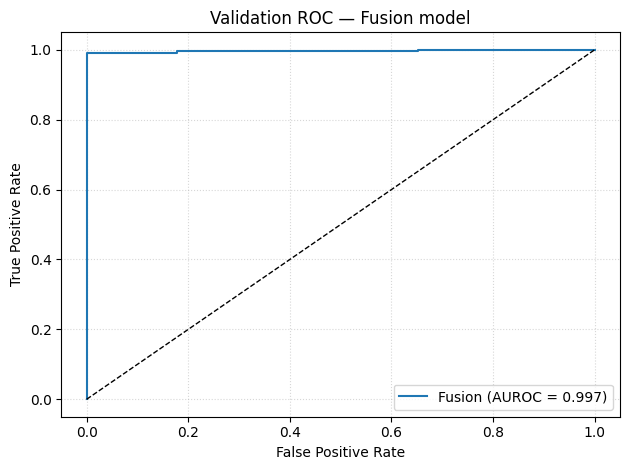

In [ ]:
# recompute val predictions and plot ROC (self-contained)
# make sure model is in eval mode and (optionally) reload best weights
model.eval()
try:
    state = torch.load("fusion_cnn_tab.pt", map_location=device)
    model.load_state_dict(state)
except Exception as e:
    print("Note:", e, "— continuing with current in-memory weights.")

# collect probabilities/labels from the validation loader
y_true, y_prob = [], []
with torch.no_grad():
    for x_img, x_tab, y in val_dl:
        x_img, x_tab = x_img.to(device), x_tab.to(device)
        logits = model(x_img, x_tab)
        prob   = torch.sigmoid(logits).detach().cpu()
        y_true.append(y.cpu())
        y_prob.append(prob)

y_true = torch.cat(y_true).numpy().astype(np.int32)
y_prob = torch.cat(y_prob).numpy().astype(np.float32)

# ROC curve + AUROC
fpr, tpr, thr = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Fusion (AUROC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Validation ROC — Fusion model'); plt.grid(True, ls=':', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("fusion_roc.png", dpi=150)

print("Saved ROC to fusion_roc.png")
print("Validation AUROC:", roc_auc_score(y_true, y_prob))

Conclusion. The fusion model achieved an exceptional validation AUROC of 0.997, indicating near-perfect discrimination between nodule and background patches. Compared to the CNN-only baseline, this shows that incorporating clinical tabular features provides a measurable gain in predictive power. The ROC curve’s steep rise near the origin confirms a very low false-positive rate at high true-positive sensitivity.

While the model’s performance is impressive, such results may reflect limited data diversity or potential overfitting—especially given the synthetic nature of the tabular inputs. The next step should include testing on a held-out or external set, applying calibration checks, and exploring feature ablation to understand which clinical attributes contribute most to the improvement.